<a href="https://colab.research.google.com/github/metrythm-AB/RAG-Implementation/blob/main/MultiModal_Rag_for_both_Text_%26_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
!pip install pinecone-client transformers torch sentence-transformers

In [68]:
import pinecone
from transformers import CLIPProcessor, CLIPModel
from sentence_transformers import SentenceTransformer
from PIL import Image
import torch
from IPython.display import display


In [69]:
from pinecone import Pinecone, ServerlessSpec
pc = Pinecone(api_key="da1ce8b8-1a1f-47a8-bb77-677c68a0a17f",environment='us-east-1')
index_name = 'multi-modal-rag-combined'
if index_name not in pc.list_indexes():
  pc.create_index(name=index_name,dimension=896, metric='cosine', spec={'serverless':{'cloud':'aws','region':'us-east-1'}})



In [70]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [71]:

texts=["The Empire State Building is a 102-story Art Deco skyscraper in the Midtown South neighborhood of Manhattan in New York City. The building was designed by Shreve, Lamb & Harmon and built from 1930 to 1931. Its name is derived from Empire State, the nickname of the state of New York. The building has a roof height of 1,250 feet (380 m) and stands a total of 1,454 feet (443.2 m) tall, including its antenna. The Empire State Building was the world's tallest building until the first tower of the World Trade Centre was topped out in September, following the September 11 attacks in 2001, the Empire State Building was New York City's tallest building until it was surpassed in 2012 by One World Trade Centre. As of 2022, the building is the seventh-tallest building in New York, the ninth-tallest completed skyscraper in the United States, and the 54th-tallest in the world."

      "The Mercedes-Maybach S680 has a 6.0-liter twin-turbo V12 engine that produces 621 horsepower and 664 lb-ft of torque.Premium unleaded gasoline with Fuel capacity of 22.2 gallons plus Compression ratio of 9.0:1 and a Construction ofDiecast alloy block and heads.The S680 also has a nine-speed automatic transmission and Mercedes' 4Matic all-wheel drive system. It can accelerate from 0 to 60 mph in 4.4 seconds, but its top speed is electronically limited to 130 mph."

      "The Toyota Supra is a sports car and grand tourer manufactured by the Toyota Motor Corporation beginning in 1978. The name supra is derived from the Latin prefix, meaning above, to surpass or go beyond. The initial four generations of the Supra were produced from 1978 to 2002. The fifth generation has been produced since March 2019 and went on sale in May 2019.The styling of the original Supra was derived from the Toyota Celica, but it was longer.The first, second and third generations of the Supra were assembled at the Tahara plant in Tahara, Aichi, while the fourth generation was assembled at the Motomachi plant in Toyota City. The 5th generation of the Supra is assembled alongside the G29 BMW Z4 in Graz, Austria by Magna Steyr."

      "The 2024 Mercedes-AMG G 63 can go from 0 to 100 km/h (62 mph) in 4.3 seconds when equipped with the optional AMG Performance Package. It has a top speed of 240 km/h (149 mph). The G63 also has a maximum towing capacity of 7,716 pounds and trailer stability assist software."

      "The Tata Curvv EV can charge from 10–80% in 40 minutes using a 70 kW or higher DC fast charger. It can also charge from 10–100% in 6.5 hours with a 7.2 kW AC charger for the 45 kWh battery pack, and almost 8 hours for the 55 kWh battery pack. The Curvv EV's battery pack uses prismatic cells that help with faster charging times."

      "Big Ben is the nickname for the Great Bell of the Great Clock of Westminster,and, by extension, for the clock tower itself,which stands at the north end of the Palace of Westminster in London, England. Originally known simply as the Clock Tower, it was renamed Elizabeth Tower in 2012 to mark the Diamond Jubilee of Elizabeth II. The clock is a striking clock with five bells.The tower was designed by Augustus Pugin in a Perpendicular Gothic Revival style and was completed in 1859."

      "The red fox (Vulpes vulpes) is the largest of the true foxes and one of the most widely distributed members of the order Carnivora, being present across the entire Northern Hemisphere including most of North America, Europe and Asia, plus parts of North Africa. It is listed as least concern on the IUCN Red List.Its range has increased alongside human expansion, having been introduced to Australia, where it is considered harmful to native small and medium-sized rodents and marsupials. Due to its impact on native species, it is included on the list of the world's 100 worst invasive species."

      "The red deer (Cervus elaphus) is one of the largest deer species. A male red deer is called a stag or hart, and a female is called a doe or hind. The red deer inhabits most of Europe, the Caucasus Mountains region, Anatolia, Iran, and parts of western Asia. It also inhabits the Atlas Mountains of Northern Africa; being the only living species of deer to inhabit Africa. Red deer have been introduced to other areas, including Australia, New Zealand, the United States, Canada, Peru, Uruguay, Chile and Argentina.In many parts of the world, the meat (venison) from red deer is used as a food source."

      "The Parthenon is a resplendent marble temple built between 447 and 432 B.C. during the height of the ancient Greek Empire. Dedicated to the Greek goddess Athena, the Parthenon sits high atop a compound of temples known as the Acropolis of Athens."]

image_paths=[
            '/Empire State.jpg',
            '/s680.jpg',
            '/supra.jpg',
            '/g63.jpg',
            '/curve.jpg',
            '/Big Ben.jpg',
            '/ Fox.jpg',
            '/deer.jpg',
            '/Parthenon.jpg']


In [72]:
text_embeddings = text_model.encode(texts)
image_embeddings = []
for image_path in image_paths:
    image = Image.open(image_path)
    inputs = clip_processor(images=image, return_tensors="pt")
    image_embedding = clip_model.get_image_features(**inputs)
    image_embeddings.append(image_embedding)



In [73]:
combined_embeddings = []
for i in range(len(texts)):
    text_tensor = torch.tensor(text_embeddings[i])
    combined_embedding = torch.cat([text_tensor, image_embeddings[i][0]], dim=-1)
    combined_embeddings.append((str(i), combined_embedding.tolist()))

In [74]:
index = pc.Index(index_name)
index.upsert(vectors=combined_embeddings)

{'upserted_count': 1}

In [75]:
query_text = "Mercedes-AMG G 63"  # Example query
query_image = Image.open('/g63.jpg')

In [76]:
query_text_embedding = text_model.encode([query_text])
query_image = Image.open(query_image_path)
query_image_inputs = clip_processor(images=query_image, return_tensors="pt")
query_image_embedding = clip_model.get_image_features(**query_image_inputs)

In [78]:
query_text_tensor = torch.tensor(query_text_embedding)
query_combined_embedding = torch.cat([query_text_tensor, query_image_embedding], dim=-1)

In [79]:
query_embedding_list = query_combined_embedding.squeeze(0).tolist()
result = index.query(vector=query_embedding_list, top_k=3)

Matching Text: The Empire State Building is a 102-story Art Deco skyscraper in the Midtown South neighborhood of Manhattan in New York City. The building was designed by Shreve, Lamb & Harmon and built from 1930 to 1931. Its name is derived from Empire State, the nickname of the state of New York. The building has a roof height of 1,250 feet (380 m) and stands a total of 1,454 feet (443.2 m) tall, including its antenna. The Empire State Building was the world's tallest building until the first tower of the World Trade Centre was topped out in September, following the September 11 attacks in 2001, the Empire State Building was New York City's tallest building until it was surpassed in 2012 by One World Trade Centre. As of 2022, the building is the seventh-tallest building in New York, the ninth-tallest completed skyscraper in the United States, and the 54th-tallest in the world.The Mercedes-Maybach S680 has a 6.0-liter twin-turbo V12 engine that produces 621 horsepower and 664 lb-ft of 

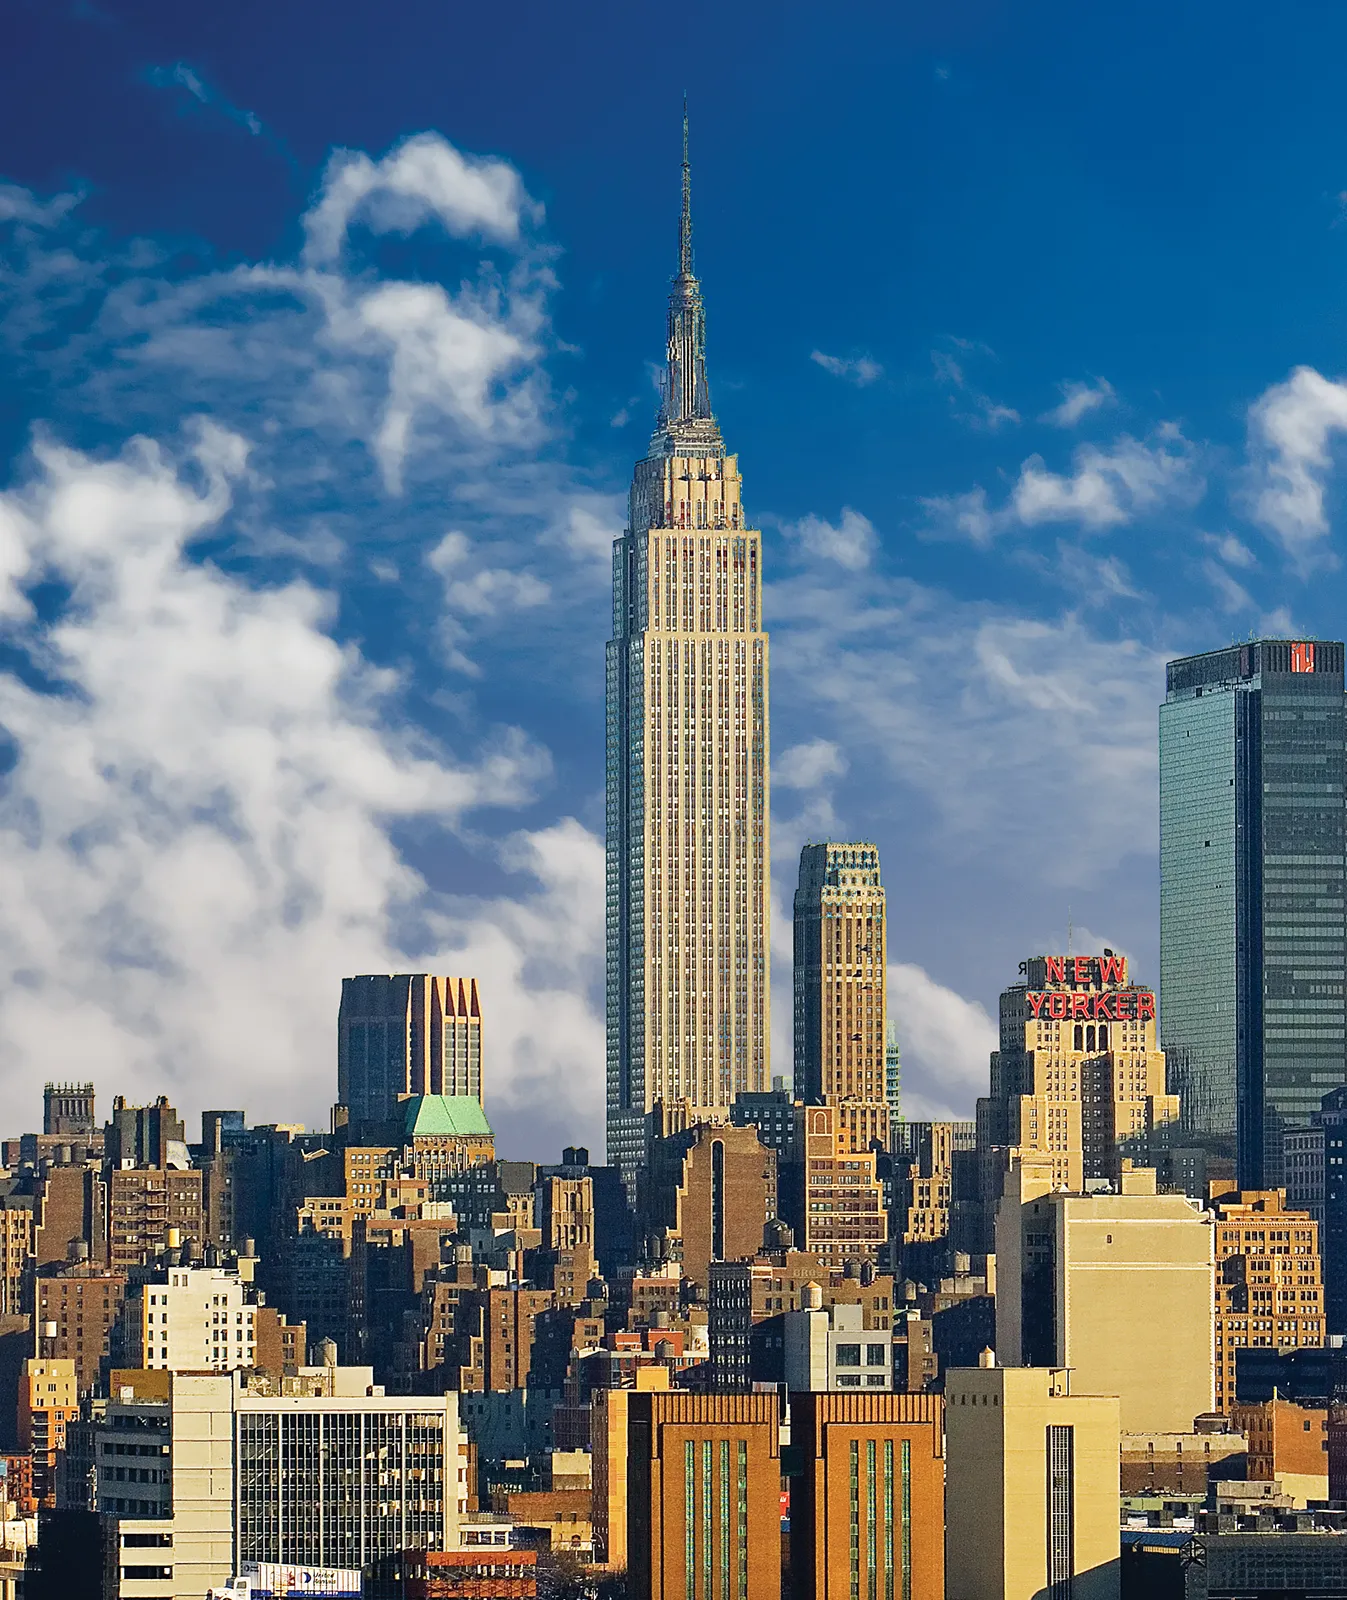

In [80]:
for match in result['matches']:
    match_id = int(match['id'])
    print(f"Matching Text: {texts[match_id]}")
    print(f"Matching Image Path: {image_paths[match_id]}")
    matching_image = Image.open(image_paths[match_id])
    display(matching_image)